INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     Quarter         Revenue
0 2020-12-31  22,788,203,973
1 2021-03-31  21,217,918,523
2 2021-06-30  21,795,084,894
3 2021-09-30  23,398,485,062
4 2021-12-31  25,936,559,794
5 2022-03-31  23,697,336,324


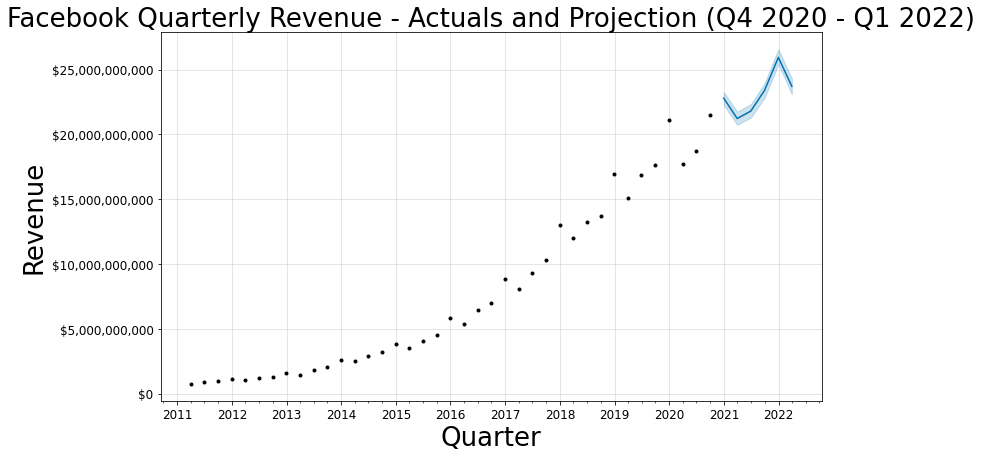

In [41]:
import pandas as pd
from fbprophet import Prophet
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

powers = { 'B': 10 ** 9, 'M': 10 ** 6 } #for breaking out the text revenue eg. $21.2BN to integer vals
qs = [ '03-31', '06-30', '09-30', '12-31' ] #quarterly end dates

def convert_mill_bill_to_numbers( num_str ):
    match = re.search(r"([0-9\.]+)\s?(M|B)", num_str).groups()
    if match is not None:
        quantity = match[ 0 ]
        magnitude = match[ 1 ]
        return_val = float( quantity ) * powers[ magnitude ]
        return return_val
    
def build_forecast_list( fb_rev, end_date ):
    #get remainder of this year
    start_year = fb_rev.iloc[ 0,: ][ 'ds' ].year
    to_add = [ str( start_year ) + '-' + q for q in qs[ int( fb_rev.iloc[ 0,: ][ 'ds' ].month / 3 ): ]]
    start_year += 1

    #add 1 year of quarters
    
    this_q = None
    while this_q != end_date:
        for q in qs:
            this_q = str( start_year ) + '-' + str( q )
            to_add.append( this_q )
            if q == '12-31':
                start_year += 1
            if this_q == end_date:
                return to_add

#format the data from the revenue spreadhseet
fb_rev = pd.read_csv( 'Facebook Revenue - Sheet1.csv', header=None )
fb_rev.columns = [ 'a', 'LastDayOfQuarter', 'Revenue' ] #a is a placeholder, ds is quarter name, y is revenue
fb_rev = fb_rev.drop( columns=['a'] )

fb_rev[ 'LastDayOfQuarter' ] = pd.to_datetime( fb_rev[ 'LastDayOfQuarter' ], format='%m-%d-%Y' )
fb_rev[ 'Revenue' ] = fb_rev[ 'Revenue' ].apply( lambda x: convert_mill_bill_to_numbers( x ) ).astype('int64')
fb_rev.columns = [ 'ds', 'y' ]
to_add = build_forecast_list( fb_rev, end_date = '2022-03-31' ) #run projections through Q1 2022

forecast_quarters = pd.DataFrame( to_add, columns=[ 'ds' ], index=[ z for z in range( len( fb_rev ), len( fb_rev ) + len( to_add ), 1 ) ] )

#invoke Prophet and project
m = Prophet()
m.add_seasonality( name='quarterly', period=91.5, fourier_order=2 ) #quarterly seasonality
m.fit( fb_rev )

forecast = m.predict( forecast_quarters )
forecast[ [ 'ds', 'yhat', 'yhat_lower', 'yhat_upper' ] ].tail()

#plot the forecast
fig1 = m.plot( forecast, xlabel='Quarter', ylabel='Revenue' )
ax = fig1.gca()
ax.set_title( "Facebook Quarterly Revenue - Actuals and Projection (Q4 2020 - Q1 2022)", size=26 )
ax.set_xlabel( "Quarter", size=26 )
ax.set_ylabel( "Revenue", size=26 )
ax.tick_params( axis="x", labelsize=12 )
ax.tick_params( axis="y", labelsize=12 )

fmt = '${x:,.0f}' # dollar thousands format
tick = mtick.StrMethodFormatter( fmt )
ax.yaxis.set_major_formatter( tick ) 
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator( ( 1,4,7,10 ) ) #get the quarters fro marking on the graph

yearsFmt = mdates.DateFormatter('%Y')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

#human readable labels
forecast[ 'Quarter' ] = forecast[ 'ds' ]
forecast[ 'Revenue' ] = forecast[ 'yhat' ].astype( 'int64' )
forecast[ 'Revenue' ] = forecast.apply( lambda x: "{:,}".format( x['Revenue'] ), axis=1)

print( forecast[ ['Quarter', 'Revenue'] ] )
